## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [ ]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [ ]:
train = np.loadtxt('/content/train-2.csv', delimiter=',', skiprows=1)
test = np.loadtxt('/content/test.csv', delimiter=',', skiprows=1)

In [ ]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [ ]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

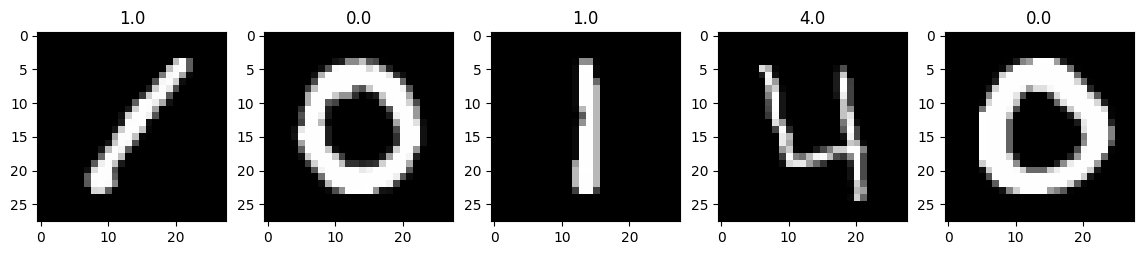

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## **ЧАСТЬ 1. Базовое решение**

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [ ]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [ ]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [ ]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [ ]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

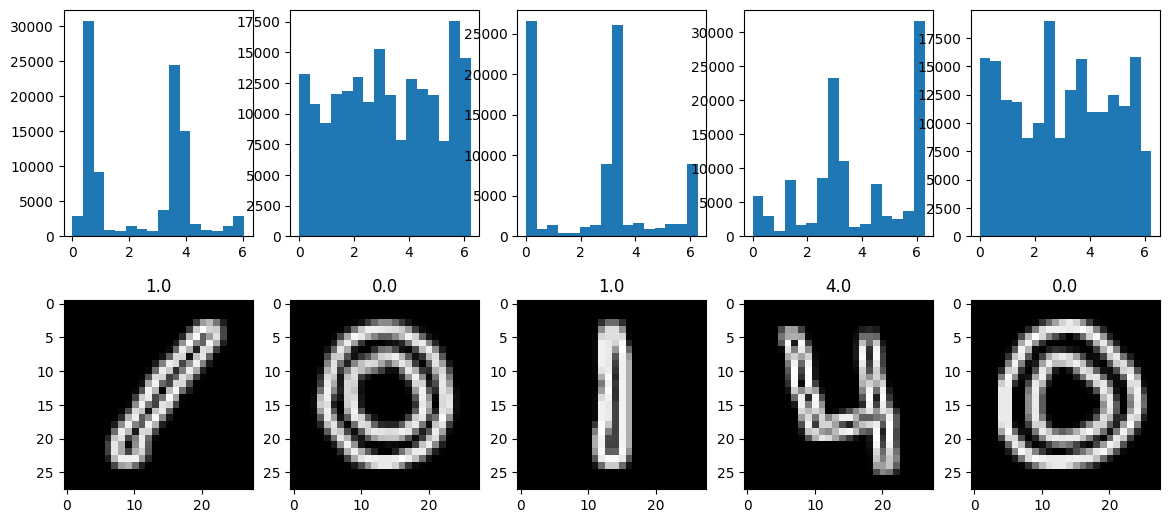

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [ ]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [ ]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [ ]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [ ]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [ ]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [ ]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [ ]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [ ]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.4270238095238095


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.34      0.12      0.18       816
         1.0       0.59      0.76      0.66       909
         2.0       0.33      0.29      0.31       846
         3.0       0.55      0.49      0.51       937
         4.0       0.33      0.31      0.32       839
         5.0       0.46      0.67      0.55       702
         6.0       0.24      0.45      0.31       785
         7.0       0.73      0.41      0.53       893
         8.0       0.39      0.49      0.44       835
         9.0       0.48      0.27      0.34       838

    accuracy                           0.43      8400
   macro avg       0.44      0.43      0.42      8400
weighted avg       0.45      0.43      0.42      8400



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[102  24  82  30 106  18 221   7 179  47]
 [  0 692   2   0  44   1 139  17  13   1]
 [ 21   0 245 158  12 203  54  16 119  18]
 [ 14   0 113 456   3 235   7   2  98   9]
 [ 11 248   5   2 260   0 205  43  37  28]
 [  3   0  84  97   5 472   3   4  33   1]
 [ 53  26  66  11 116   4 355  13  76  65]
 [  4 113  38  16  66  41 189 368  15  43]
 [ 81   6  68  44  36  44 107   3 411  35]
 [ 11  73  31  20 149  11 222  30  65 226]]


## Предсказания на тестовыйх данных

In [ ]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

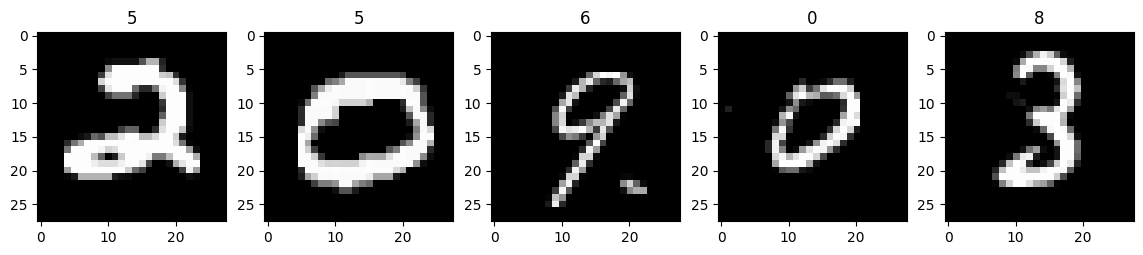

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
!head submit.txt

ImageId,Label
1,5
2,5
3,6
4,0
5,8
6,7
7,6
8,3
9,8


In [ ]:
# Your submission scored 0.41700

## **ЧАСТЬ 2. Подбор лучшей модели**

In [ ]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((33600, 16), (8400, 16), (33600,), (8400,))

**LogisticRegression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.simplefilter('ignore')

In [ ]:
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
    'C': [0.1, 0.25, 0.5, 1.0]
}

In [ ]:
lr = LogisticRegression(random_state=42)
rscv_lr = RandomizedSearchCV(lr, lr_params, cv=10, scoring='accuracy')
rscv_lr.fit(x_train, y_train)

RandomizedSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
                   param_distributions={'C': [0.1, 0.25, 0.5, 1.0],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'sag', 'saga',
                                                   'lbfgs']},
                   scoring='accuracy')

In [ ]:
print(rscv_lr.best_params_)
print(rscv_lr.best_score_)
print(rscv_lr.best_estimator_)

{'solver': 'saga', 'penalty': 'l1', 'C': 0.25}
0.5831547619047619
LogisticRegression(C=0.25, penalty='l1', random_state=42, solver='saga')


**RandomForestClassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc_params = {
    'n_estimators': [5, 10, 20, 40, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1, 3, 5, 7, 9, None],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rscv_rfc = RandomizedSearchCV(rfc, rfc_params, cv=10, scoring='accuracy')
rscv_rfc.fit(x_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [1, 3, 5, 7, 9, None],
                                        'min_samples_leaf': [1, 2, 4, 8, 16],
                                        'n_estimators': [5, 10, 20, 40, 100]},
                   scoring='accuracy')

In [ ]:
print(rscv_rfc.best_params_)
print(rscv_rfc.best_score_)
print(rscv_rfc.best_estimator_)

{'n_estimators': 100, 'min_samples_leaf': 8, 'max_depth': None, 'criterion': 'entropy'}
0.6397916666666668
RandomForestClassifier(criterion='entropy', min_samples_leaf=8, random_state=42)


**KNeighborsClassifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

In [ ]:
knc = KNeighborsClassifier(n_jobs=-1)
rscv_knc = RandomizedSearchCV(knc, knn_params, cv=10, scoring='accuracy')
rscv_knc.fit(x_train, y_train)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(n_jobs=-1),
                   param_distributions={'n_neighbors': [1, 3, 5, 7, 9, 11],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy')

In [ ]:
print(rscv_knc.best_params_)
print(rscv_knc.best_score_)
print(rscv_knc.best_estimator_)

{'weights': 'uniform', 'p': 2, 'n_neighbors': 11}
0.6084226190476191
KNeighborsClassifier(n_jobs=-1, n_neighbors=11)


**Промежуточные итоги**

In [ ]:
val_acc_lr = rscv_lr.best_estimator_.score(x_val, y_val)
val_acc_rfc = rscv_rfc.best_estimator_.score(x_val, y_val)
val_acc_knc = rscv_knc.best_estimator_.score(x_val, y_val)

In [ ]:
import pandas as pd

In [ ]:
res_0 = pd.DataFrame(
    {'cv_accuracy': [rscv_lr.best_score_, rscv_rfc.best_score_, rscv_knc.best_score_],
     'val_accuracy': [val_acc_lr, val_acc_rfc, val_acc_knc]},
    index=['LogisticRegression', 'RandomForestClassifier', 'KNeighborsClassifier']
    )
res_0

,cv_accuracy,val_accuracy
LogisticRegression,0.583155,0.582024
RandomForestClassifier,0.639792,0.641190
KNeighborsClassifier,0.608423,0.603810


Модель **RandomForestClassifier** показала лучший результат как на тренировочных, так и на валидационных данных.

Далее будем использовать именно ее.

## **Часть 3. Нормализация данных при помощи PCA / Результаты Kaggle**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=0.95)

full_img = np.vstack([train_img.reshape(-1, 28 * 28), test_img.reshape(-1, 28 * 28)])
full_img_pca = pca.fit_transform(full_img)

train_img_pca = full_img[:train_img.shape[0], :]
test_img_pca = full_img[train_img.shape[0]:, :]

In [ ]:
y_train2, y_val2, x_train2, x_val2 = train_test_split(train_label, train_img_pca, test_size=0.2, random_state=42)


In [ ]:
y_train2.shape, y_val2.shape, x_train2.shape, x_val2.shape

((33600,), (8400,), (33600, 784), (8400, 784))

In [ ]:
print(f'Количество компонент после PCA : {pca.n_components_}')

Количество компонент после PCA : 154


In [ ]:
print(rscv_rfc.best_params_)
print(rscv_rfc.best_score_)
print(rscv_rfc.best_estimator_)

{'n_estimators': 100, 'min_samples_leaf': 8, 'max_depth': None, 'criterion': 'entropy'}
0.6397916666666668
RandomForestClassifier(criterion='entropy', min_samples_leaf=8, random_state=42)


In [ ]:
rfc_final = RandomForestClassifier(n_estimators=100,
                                   min_samples_leaf=8,
                                   max_depth=None,
                                   criterion='entropy',
                                   random_state=42)

rfc_final.fit(x_train2, y_train2)
rfc_final_pred = rfc_final.predict(x_val2)

print(f'acc_rfc_final: {accuracy_score(y_val2, rfc_final_pred)}')

acc_rfc_final: 0.9521428571428572


In [ ]:
print(classification_report(y_val2, rfc_final_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       816
         1.0       0.97      0.99      0.98       909
         2.0       0.95      0.94      0.94       846
         3.0       0.95      0.93      0.94       937
         4.0       0.95      0.96      0.95       839
         5.0       0.95      0.93      0.94       702
         6.0       0.95      0.97      0.96       785
         7.0       0.96      0.94      0.95       893
         8.0       0.95      0.94      0.95       835
         9.0       0.92      0.93      0.93       838

    accuracy                           0.95      8400
   macro avg       0.95      0.95      0.95      8400
weighted avg       0.95      0.95      0.95      8400



In [ ]:
print(confusion_matrix(y_val2, rfc_final_pred))

[[802   0   2   2   1   0   6   0   3   0]
 [  0 897   5   1   1   2   1   2   0   0]
 [  2   7 798   3  12   2   6  10   5   1]
 [  1   3   9 869   2  20   2   8  13  10]
 [  2   0   1   1 806   1   7   3   0  18]
 [  6   1   2  11   1 655  12   2   7   5]
 [  5   1   2   0   2   2 765   1   7   0]
 [  1   4  16   1   8   0   0 839   3  21]
 [  1   5   6   9   6   3   4   2 788  11]
 [  2   4   3  16  13   6   0  10   5 779]]


In [ ]:
pred_test = rfc_final.predict(test_img_pca)

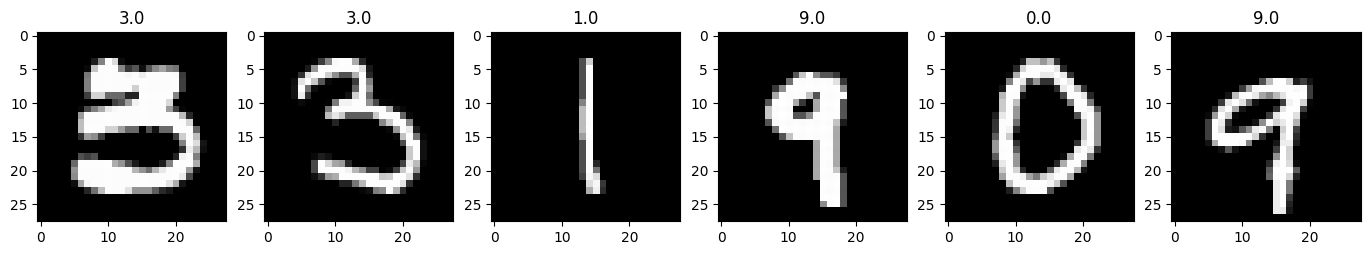

In [ ]:
fig = plt.figure(figsize=(20, 10))

for i, img in enumerate(test_img[15:21], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[15 + i - 1]);

## Готовим файл для отправки

In [ ]:
def submit(pred, file_name='submit_final.txt'):
    with open(file_name, 'w') as dst:
        dst.write('ImageId,Label\n')
        for i, p in enumerate(pred, 1):
            dst.write('%s,%s\n' % (i, p))

In [ ]:
submit(pred_test.astype(np.int32))

In [ ]:
!head submit_final.txt

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0


In [ ]:
submit_final_csv = pd.read_csv("/content/submit_final.txt",
                           delimiter = ',')
submit_final_csv.to_csv('submit_final_csv.csv',
               index = None)

In [ ]:
# Your submission scored: 0.95364

In [ ]:
from IPython.display import Image

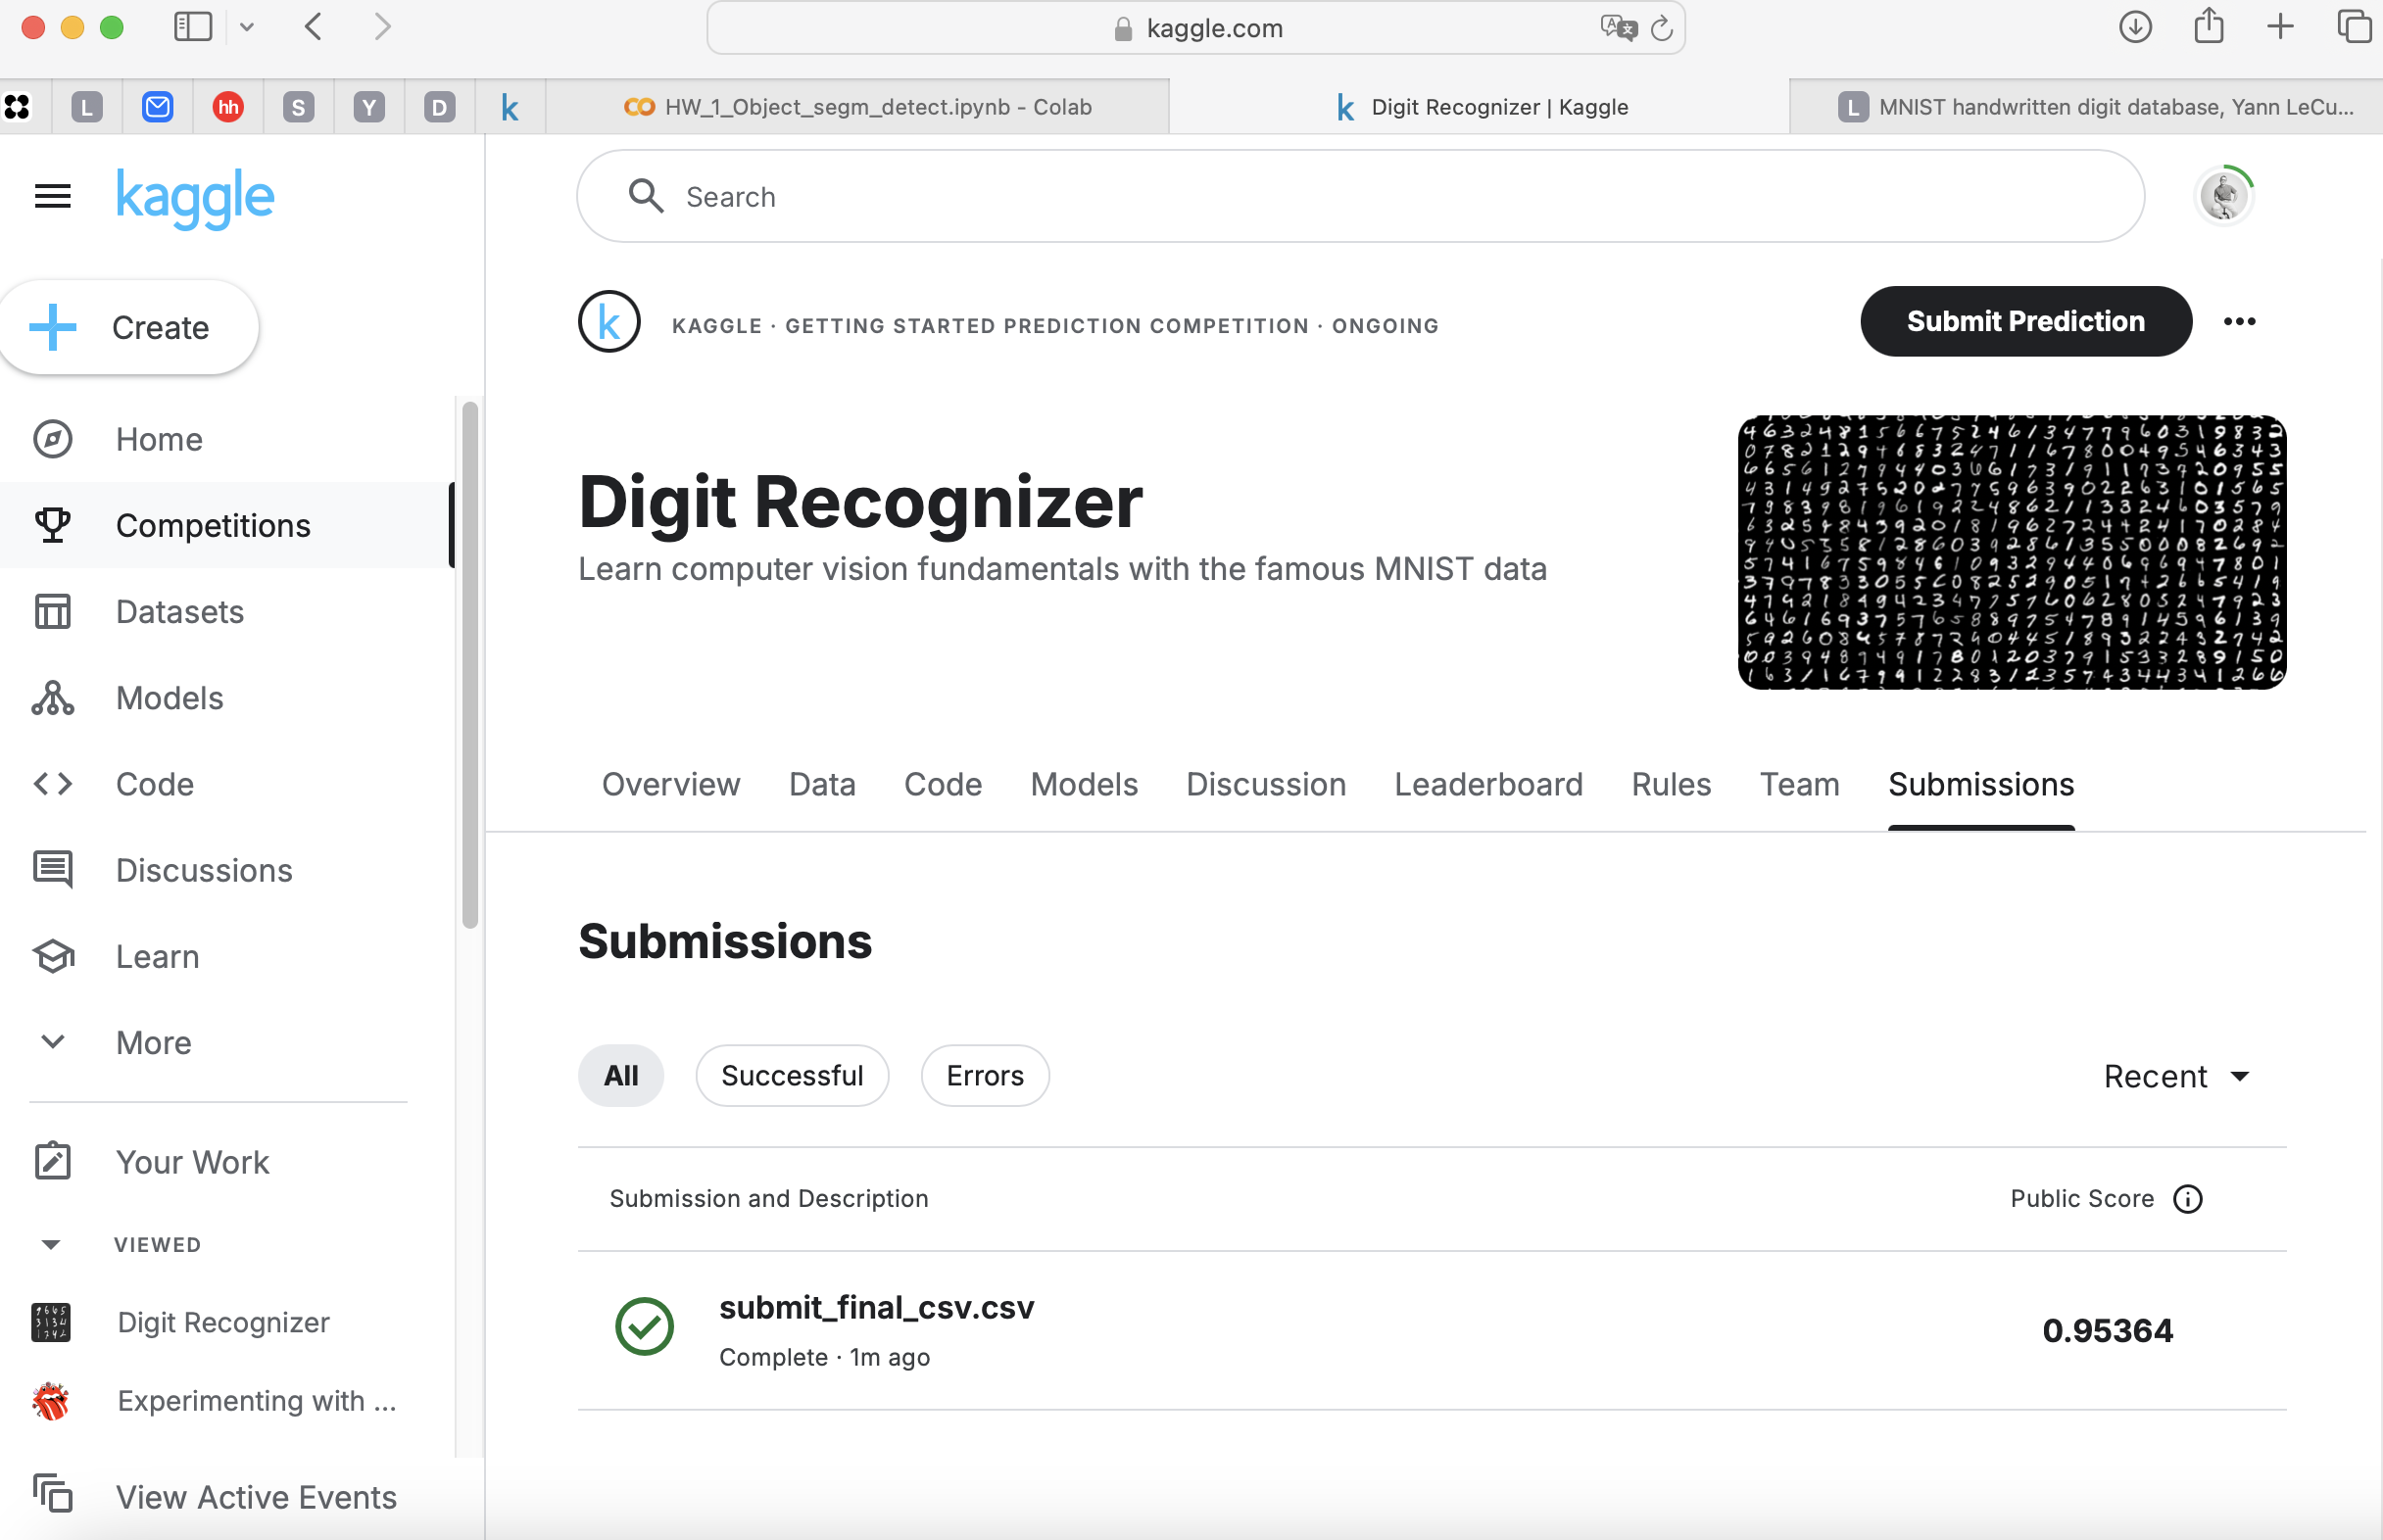

In [ ]:
Image("/content/Снимок экрана 2024-12-04 в 13.31.30.png")

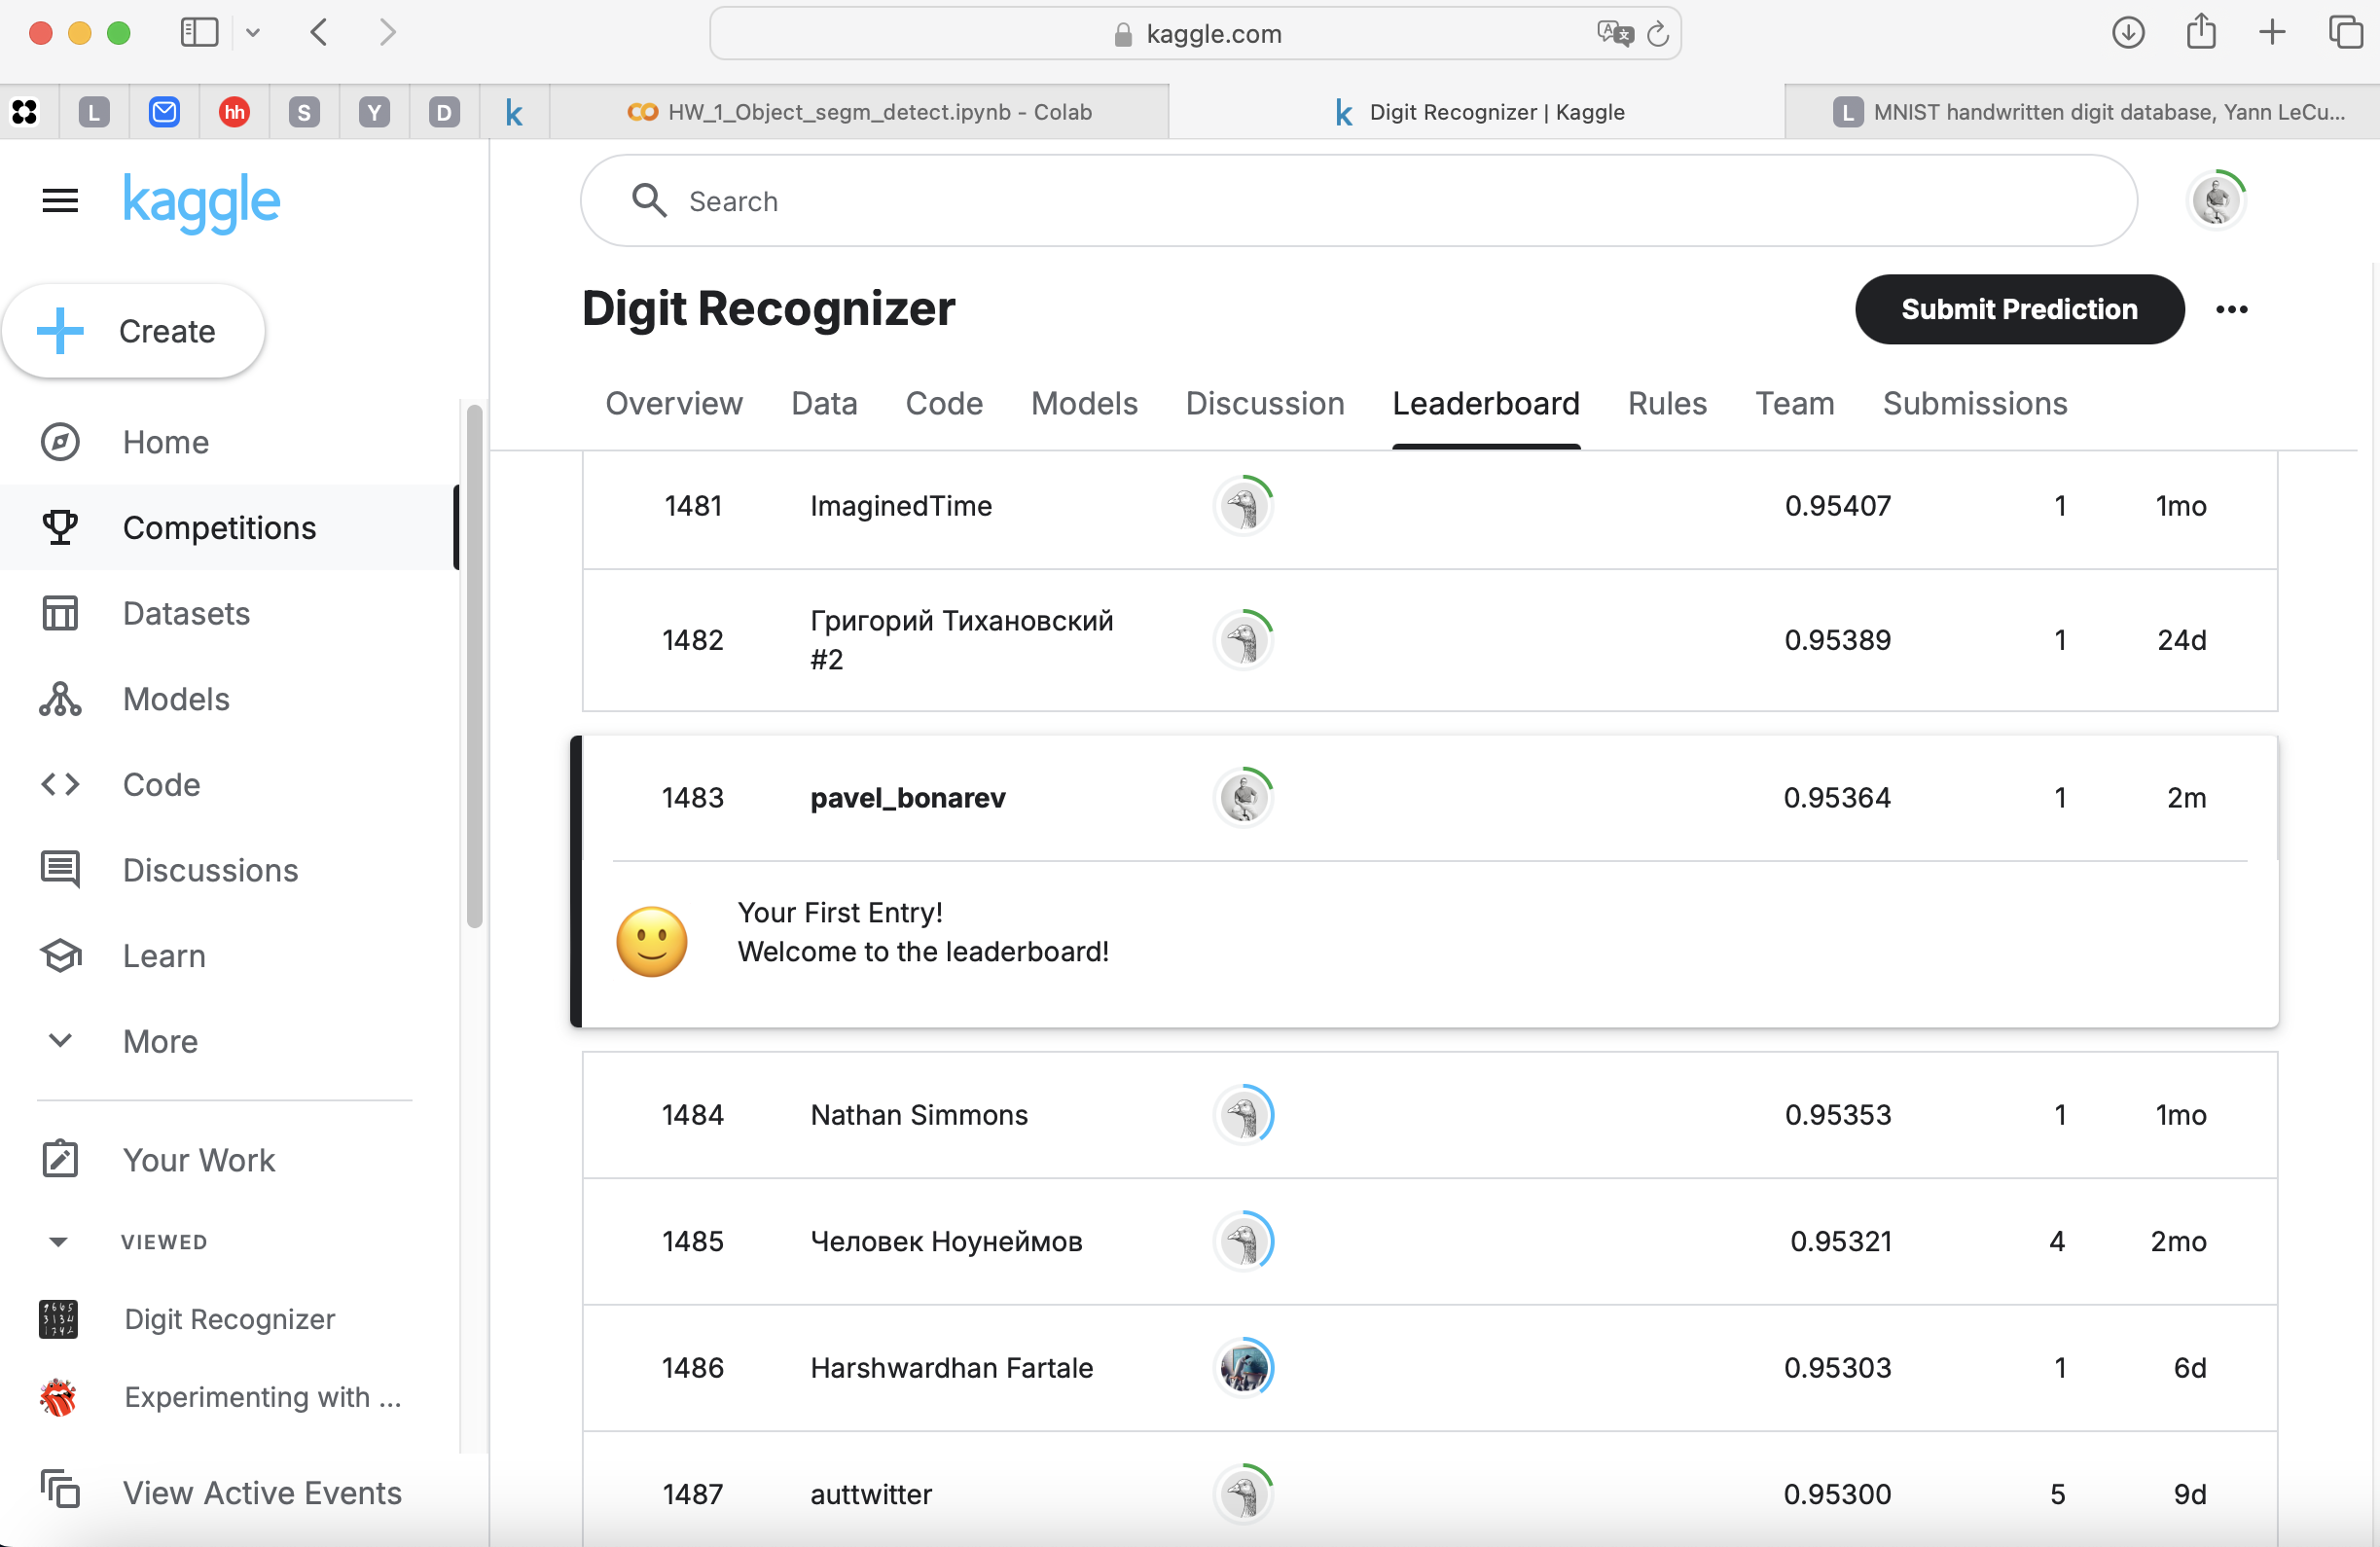

In [ ]:
Image("/content/Снимок экрана 2024-12-04 в 13.32.02.png")